In [1]:
import tensorflow as tf

assert tf.__version__ >= "2.0"

import keras_tuner as kt
import numpy as np

tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt

import cv2

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

2024-07-22 18:15:03.468380: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 18:15:03.541758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 18:15:03.585493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 18:15:03.594856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 18:15:03.648624: I tensorflow/core/platform/cpu_feature_guar

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

In [3]:
def print_accuracy_scores(train_labels, test_labels, predictions_train_model, predictions_test_model):
    acc_train = accuracy_score(train_labels, predictions_train_model)
    acc_test = accuracy_score(test_labels, predictions_test_model)
    print('Training set accuracy:   {:.3f}'.format(acc_train))
    print('Test set accuracy:       {:.3f}'.format(acc_test))

def print_stats(labels, predictions, title):
    meas = precision_recall_fscore_support(labels, predictions, average=None, zero_division= np.nan)
    print(title)
    for i in range(2):
        print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={3:5.3f}'.format(i, meas[0][i], meas[1][i], meas[2][i]))

In [3]:
X = np.load("pneumonia_images.npy")
y = (np.load("pneumonia_labels.npy")).ravel()

if (len(X) != len(y)):
    raise ValueError("Numbers of images and labels do not match")

print(f"The dataset is composed by {X.shape[0]} images {X.shape[1]}x{X.shape[2]}")

bin_count = np.bincount(y)
if len(bin_count) != 2:
    raise ValueError("Labels must be 0 or 1")

print("Negative examples: ", bin_count[0])
print("Positive examples: ", bin_count[1])

if bin_count[0] != bin_count[1]:
    print("Imbalanced Dataset")
else:
    print("Balanced Dataset")

The dataset is composed by 5232 images 28x28
Negative examples:  1349
Positive examples:  3883
Imbalanced Dataset


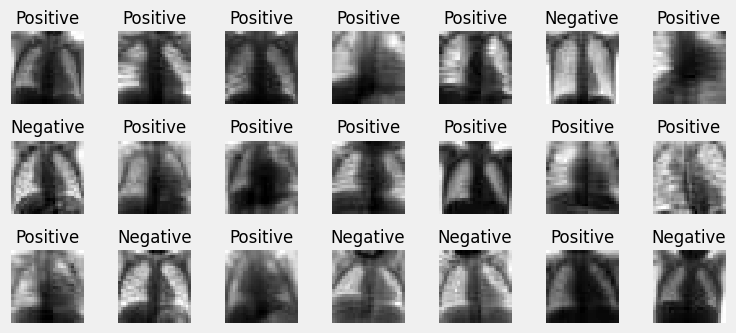

In [5]:
n_rows = 3
n_cols = 7
titles = ["Negative", "Positive"]
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(titles[y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [6]:
def extract_histogram(image, color_space, channels=(0,1,2), bins=(8, 8, 8), range=(0, 256, 0, 256, 0, 256)):
    if color_space is None:
        cvt_img = image
    else:
        cvt_img = cv2.cvtColor(image, color_space)
    hist = cv2.calcHist([cvt_img], channels, None, bins, range)
    cv2.normalize(hist, hist)
    return hist.flatten()

def get_histograms(dataset, color_space, channels, bins, channels_range):
    histograms = []
    for x in dataset:
            hist = extract_histogram(x, color_space, channels, bins, channels_range)
            histograms.append(hist)
    return histograms

def ranges(N, nb):
    step = N / nb
    return ["{},{}".format(round(step*i), round(step*(i+1))) for i in range(nb)]

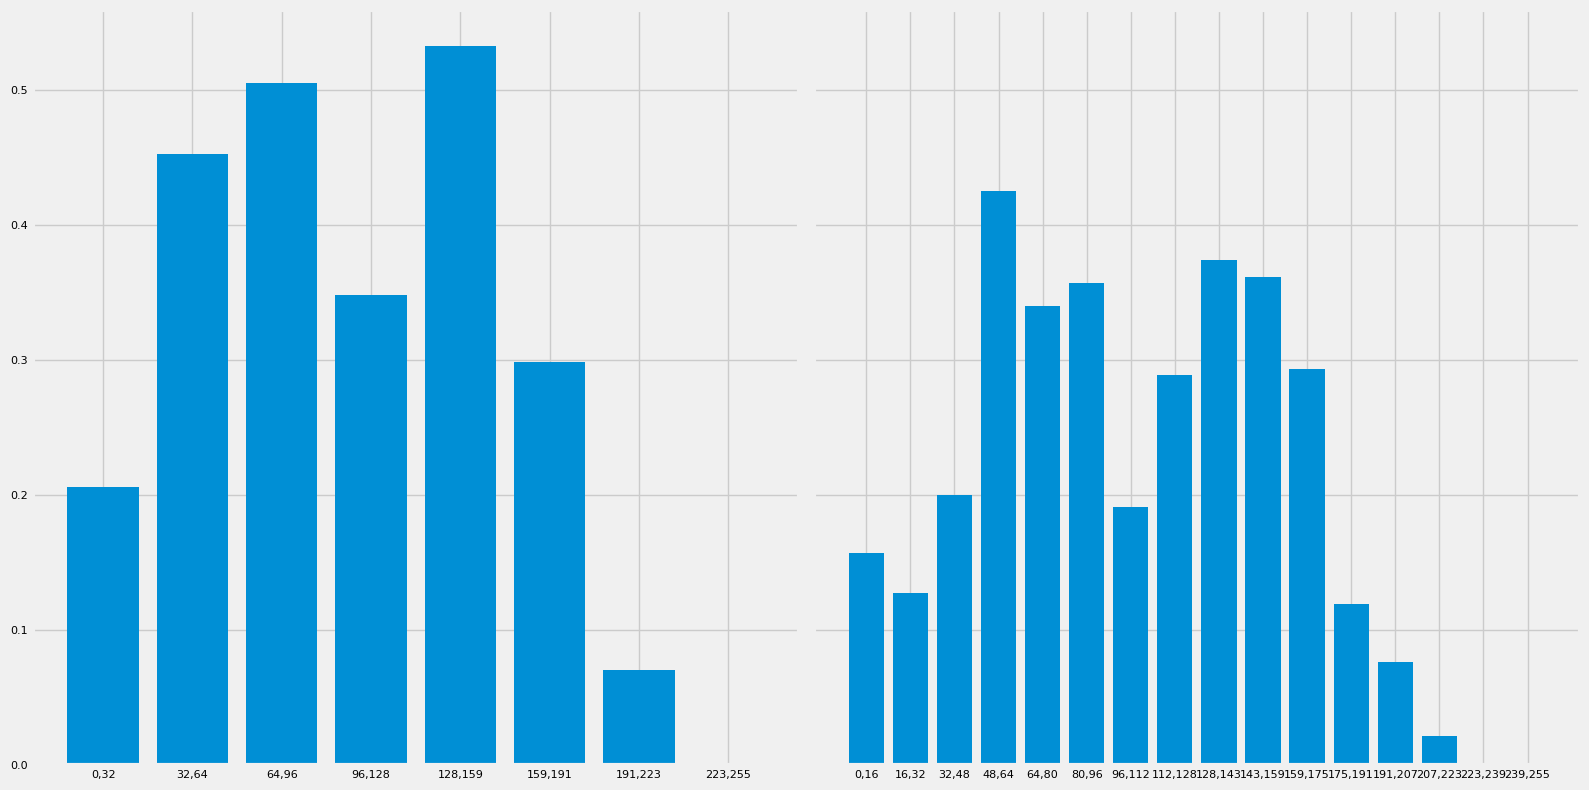

In [7]:
hist8bins = extract_histogram(X[5], None, (0,), (8,), (0, 256))
hist16bins = extract_histogram(X[5], None, (0,), (16,), (0, 256))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins)
axs[1].bar(ranges(255, 16), hist16bins)
plt.show()

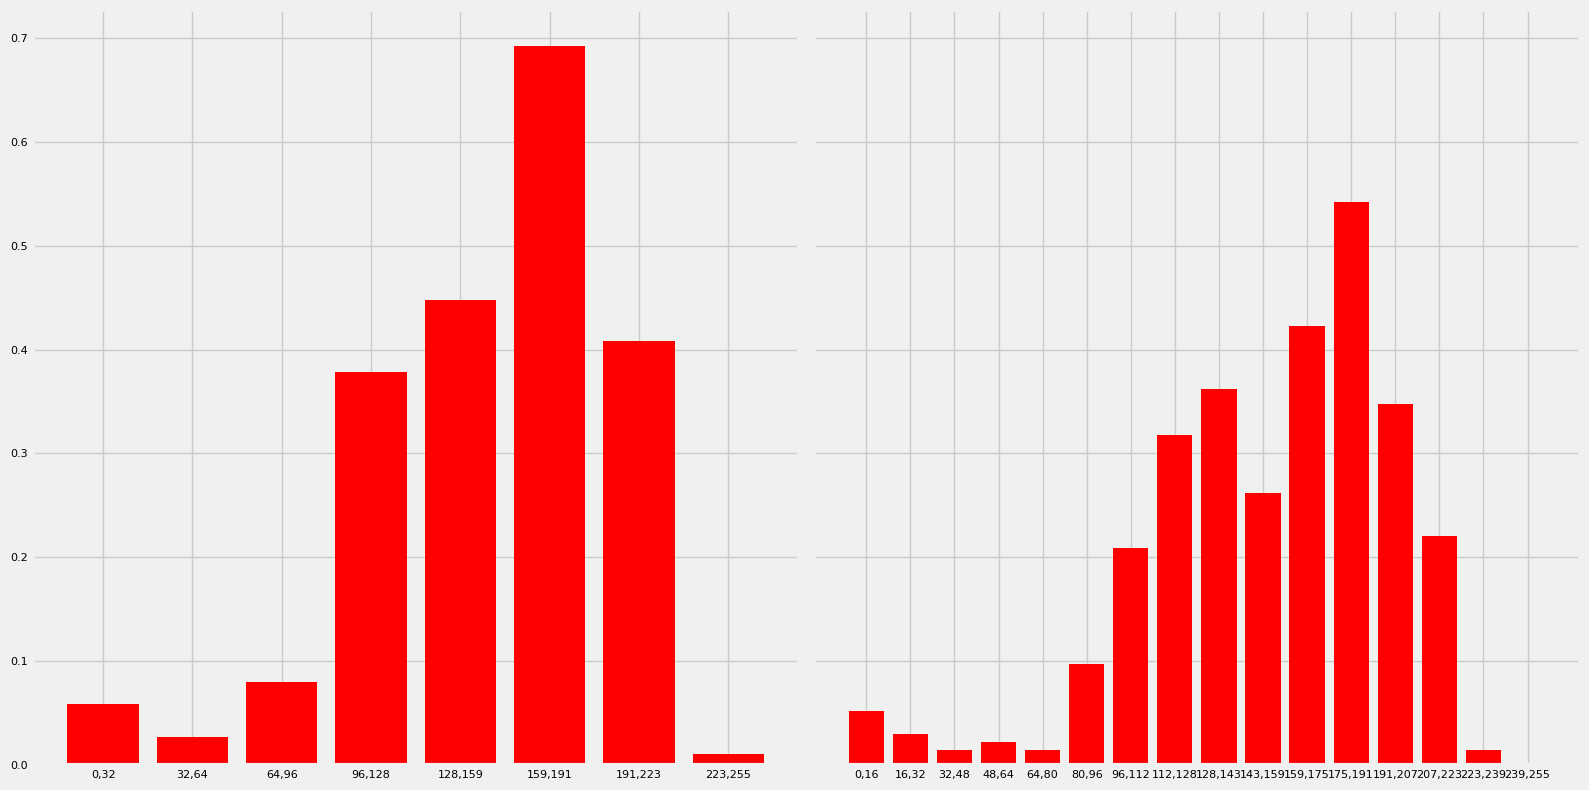

In [8]:
hist8bins = extract_histogram(X[0], None, (0,), (8,), (0, 256))
hist16bins = extract_histogram(X[0], None, (0,), (16,), (0, 256))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins, color="red")
axs[1].bar(ranges(255, 16), hist16bins, color="red")
plt.show()

In [9]:
bins_8 = np.array(get_histograms(X, None, (0,), (8,), (0, 256)))
bins_16 = np.array(get_histograms(X, None, (0,), (16,), (0, 256)))

In [10]:
def build_logistic_regression(hp):
    model = LogisticRegression(
        n_jobs=-1, 
        random_state=42,
        C=hp.Float("C", min_value=10e-6, max_value=0.1, step=10, sampling="log"),
        solver=hp.Choice("solver", ["liblinear", "saga"]),
        penalty= hp.Choice("penalty", ["l1", "l2"]))
    return model

In [11]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_logistic_regression,
    cv=StratifiedKFold(5),
    project_name='tuners/log_reg_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest C: ", best_hps.get("C"))
print("\nBest solver: ", best_hps.get("solver"))
print("\nBest penalty: ", best_hps.get("penalty"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/log_reg_hist_8bins/tuner0.json

Best C:  0.1

Best solver:  saga

Best penalty:  l1

Training set accuracy:   0.820
Test set accuracy:       0.825
Training set
Class 0: precision=0.791, recall=0.415, f-measure=0.544
Class 1: precision=0.825, recall=0.962, f-measure=0.888
Test set
Class 0: precision=0.811, recall=0.404, f-measure=0.539
Class 1: precision=0.827, recall=0.968, f-measure=0.892


In [12]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_logistic_regression,
    cv=StratifiedKFold(5),
    project_name='tuners/log_reg_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest C: ", best_hps.get("C"))
print("\nBest solver: ", best_hps.get("solver"))
print("\nBest penalty: ", best_hps.get("penalty"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/log_reg_hist_16bins/tuner0.json

Best C:  0.1

Best solver:  saga

Best penalty:  l1

Training set accuracy:   0.820
Test set accuracy:       0.820
Training set
Class 0: precision=0.788, recall=0.419, f-measure=0.547
Class 1: precision=0.825, recall=0.961, f-measure=0.888
Test set
Class 0: precision=0.808, recall=0.381, f-measure=0.518
Class 1: precision=0.822, recall=0.969, f-measure=0.890


In [13]:
def build_random_forest(hp):
    model = RandomForestClassifier(
        n_estimators=hp.Choice("n_estimators", [50, 100, 250]),
        criterion=hp.Choice("criterion", ["gini", "entropy"]),
        max_depth=hp.Choice("max_depth", [1, 5, 10]),
        max_features=hp.Choice("max_features", ["sqrt", "log2"]),
        n_jobs=-1, 
        random_state=42)
    
    return model

In [14]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_random_forest,
    cv=StratifiedKFold(5),
    overwrite=False,
    project_name='tuners/random_forest_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best max_features:       ", best_hps.get("max_features"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)  

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/random_forest_hist_8bins/tuner0.json
Best n_estimators:        100
Best criterion:           entropy
Best max_depth:           10
Best max_features:        sqrt

Training set accuracy:   0.940
Test set accuracy:       0.873
Training set
Class 0: precision=0.925, recall=0.838, f-measure=0.879
Class 1: precision=0.945, recall=0.976, f-measure=0.960
Test set
Class 0: precision=0.824, recall=0.634, f-measure=0.716
Class 1: precision=0.885, recall=0.954, f-measure=0.918


In [15]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_random_forest,
    cv=StratifiedKFold(5),
    project_name='tuners/random_forest_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best max_features:       ", best_hps.get("max_features"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Reloading Tuner from ./tuners/random_forest_hist_16bins/tuner0.json
Best n_estimators:        50
Best criterion:           entropy
Best max_depth:           10
Best max_features:        sqrt

Training set accuracy:   0.969
Test set accuracy:       0.895
Training set
Class 0: precision=0.954, recall=0.925, f-measure=0.940
Class 1: precision=0.974, recall=0.985, f-measure=0.979
Test set
Class 0: precision=0.827, recall=0.740, f-measure=0.781
Class 1: precision=0.915, recall=0.948, f-measure=0.931


In [16]:
def build_adaboost_trees(hp):
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion=hp.Choice("criterion", ["gini", "entropy"]),
            max_depth=hp.Choice("max_depth", [1, 5, 10, 15]),
            random_state=42),
        n_estimators=hp.Choice("n_estimators", [50, 100, 250, 500]),
        learning_rate=hp.Choice("learning_rate", [0.001, 0.01, 0.1, 1.0, 10.0]),
        algorithm="SAMME",
        random_state=42)
    
    return model

In [17]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_adaboost_trees,
    cv=StratifiedKFold(5),
    project_name='tuners/adaboost_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best learning_rate:      ", best_hps.get("learning_rate"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Trial 36 Complete [00h 00m 44s]
score: 0.9113715544763463

Best score So Far: 0.9183435060150724
Total elapsed time: 00h 05m 20s

Search: Running Trial #37

Value             |Best Value So Far |Hyperparameter
gini              |gini              |criterion
5                 |5                 |max_depth
500               |250               |n_estimators
0.01              |0.01              |learning_rate



KeyboardInterrupt: 

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_adaboost_trees,
    cv=StratifiedKFold(5),
    project_name='tuners/adaboost_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best learning_rate:      ", best_hps.get("learning_rate"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

In [ ]:
def build_knn(hp):
    model = KNeighborsClassifier(
        n_neighbors=hp.Int("n_neighbors", min_value=1, max_value=10, step=1),
        weights=hp.Choice("weights", ["uniform", "distance"]),
        algorithm=hp.Choice("algorithm", ["ball_tree", "kd_tree"]),
        p=hp.Float("p", min_value=1, max_value=2, step=1),
        n_jobs=-1)
    return model

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_knn,
    cv=StratifiedKFold(5),
    project_name='tuners/knn_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_neighbors:    ", best_hps.get("n_neighbors"))
print("Best weights:        ", best_hps.get("weights"))
print("Best algorithm:      ", best_hps.get("algorithm"))
print("Best p:              ", best_hps.get("p"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_knn,
    cv=StratifiedKFold(5),
    project_name='tuners/knn_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_neighbors:    ", best_hps.get("n_neighbors"))
print("Best weights:        ", best_hps.get("weights"))
print("Best algorithm:      ", best_hps.get("algorithm"))
print("Best p:              ", best_hps.get("p"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")